In [6]:
# import the required libraries
import pandas as pd
import ydata_profiling as pdpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("balanced_preprocessed_data.csv")

In [8]:
# List of columns to exclude from normalization and winsorization
excluded_columns = ['Type', 'Machine failure']

### DESCRIPTIVE ANALYTICS

## Clustering

In [9]:
X = df[[col for col in df.columns if col not in excluded_columns]]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

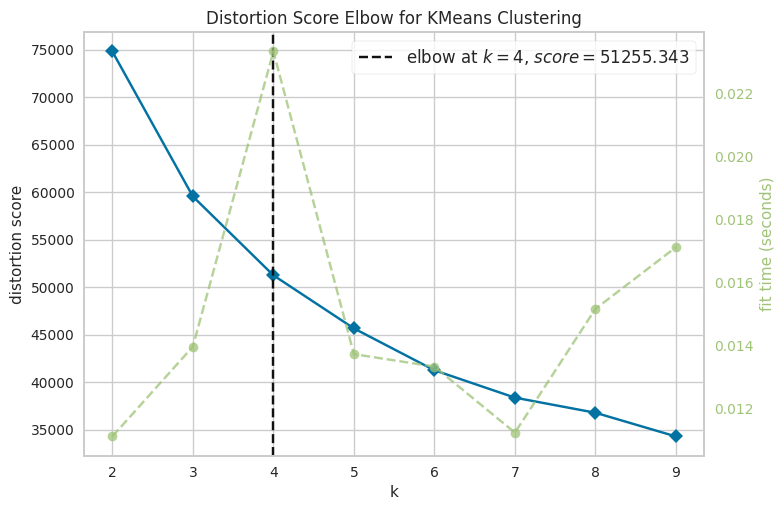

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# K-means clustering
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10)) 
visualizer.fit(X)
visualizer.show()

### clustering prep

- Feature Engineering:

Creates ensemble clustering features using multiple clustering methods
Generates distance-based features from K-means
Creates interaction features between clusters and original features


- Dimensionality Reduction:

Creates clustering features in different ways (ward, complete, average linkages)


- Feature Selection:

Uses mutual information to select relevant features
Allows threshold adjustment for feature importance

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

def create_cluster_features(df, X):
    """Create ensemble clustering features"""
    # K-means with k=4 (as suggested by elbow method)
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_distances = kmeans.transform(X)
    
    # Hierarchical clustering with different linkages
    hierarchical_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
    hierarchical_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
    hierarchical_average = AgglomerativeClustering(n_clusters=4, linkage='average')
    
    ward_labels = hierarchical_ward.fit_predict(X)
    complete_labels = hierarchical_complete.fit_predict(X)
    average_labels = hierarchical_average.fit_predict(X)
    
    # DBSCAN with adjusted parameters
    dbscan = DBSCAN(eps=1.2, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X)
    
    # Add cluster labels to dataframe
    df['kmeans_cluster'] = kmeans_labels
    df['ward_cluster'] = ward_labels
    df['complete_cluster'] = complete_labels
    df['average_cluster'] = average_labels
    df['dbscan_cluster'] = dbscan_labels
    
    # Add distance features from k-means
    for i in range(kmeans_distances.shape[1]):
        df[f'kmeans_dist_{i}'] = kmeans_distances[:, i]
    
    return df

def create_interaction_features(df):
    """Create interaction features between clusters and original features"""
    base_features = ['Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
    cluster_features = ['kmeans_cluster', 'ward_cluster', 'complete_cluster', 'average_cluster']
    
    for base in base_features:
        for cluster in cluster_features:
            df[f'{base}_{cluster}_interaction'] = df[base] * df[cluster]
    
    return df

def select_features(X, y, threshold=0.01):
    """Select features based on mutual information"""
    mi_scores = mutual_info_classif(X, y)
    selected_features = X.columns[mi_scores > threshold]
    return selected_features

def preprocess_data(df, target_col='Machine failure', excluded_cols=['Type']):
    """Main preprocessing pipeline"""
    # 1. Initial split of features and target - clearer separation
    # Filter out excluded columns that actually exist in df
    existing_cols_to_drop = [col for col in excluded_cols if col in df.columns]
    existing_cols_to_drop.append(target_col)
    
    # Prepare X (features) and y (target)
    X = df.drop(columns=existing_cols_to_drop)
    y = df[target_col]
    
    # 2. Create clustering features (using already scaled data)
    df_enriched = create_cluster_features(X.copy(), X)
    
    # 3. Create interaction features
    df_enriched = create_interaction_features(df_enriched)
    
    # 4. Feature selection
    selected_features = select_features(df_enriched, y)
    X_processed = df_enriched[selected_features]
    
    return X_processed, y, selected_features


# Preprocess data
X, y, selected_features = preprocess_data(
    df, 
    target_col='Machine failure',
    excluded_cols=['Type']  # Can easily add more columns to exclude
)

In [12]:
selected_features

Index(['Air temperature', 'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear', 'Power', 'temperature_differential', 'power_speed_ratio',
       'thermal_stress', 'operational_stress', 'efficiency_index',
       'temperature_stability', 'power_wear_interaction',
       'speed_torque_efficiency', 'wear_rate', 'kmeans_cluster',
       'ward_cluster', 'complete_cluster', 'average_cluster', 'dbscan_cluster',
       'kmeans_dist_0', 'kmeans_dist_1', 'kmeans_dist_2', 'kmeans_dist_3',
       'Process temperature_kmeans_cluster_interaction',
       'Process temperature_ward_cluster_interaction',
       'Process temperature_complete_cluster_interaction',
       'Process temperature_average_cluster_interaction',
       'Rotational speed_kmeans_cluster_interaction',
       'Rotational speed_ward_cluster_interaction',
       'Rotational speed_complete_cluster_interaction',
       'Rotational speed_average_cluster_interaction',
       'Torque_kmeans_cluster_interaction', 'Torque_

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9931 entries, 0 to 9930
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Air temperature                                   9931 non-null   float64
 1   Process temperature                               9931 non-null   float64
 2   Rotational speed                                  9931 non-null   float64
 3   Torque                                            9931 non-null   float64
 4   Tool wear                                         9931 non-null   float64
 5   Power                                             9931 non-null   float64
 6   temperature_differential                          9931 non-null   float64
 7   power_speed_ratio                                 9931 non-null   float64
 8   thermal_stress                                    9931 non-null   float64
 9   operational_stress 

In [14]:
y.value_counts()

Machine failure
0.0    5517
1.0    4414
Name: count, dtype: int64

### summary 

- Visualization Dashboard:

Feature importance visualization
Feature grouping by category (mechanical, thermal, operational)
Preprocessing summary and recommendations

- Key Findings:

Most important features are operational_stress and temperature_differential
Cluster distances provide good indicators of operational state
Interaction features capture complex failure patterns

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Then split into train/test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# Print results
print("\nDataset Shape:")
print(f"Original features shape: {X.shape}")


# To see class distribution
print("\nClass Distribution:")
print("Original:", pd.Series(y).value_counts(normalize=True))


Dataset Shape:
Original features shape: (9931, 40)

Class Distribution:
Original: Machine failure
0.0    0.555533
1.0    0.444467
Name: proportion, dtype: float64


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo


Training Data Summary:
Number of samples: 9931
Number of features: 40

Class Balance:
Machine failure
0.0    0.556
1.0    0.444
Name: proportion, dtype: float64


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

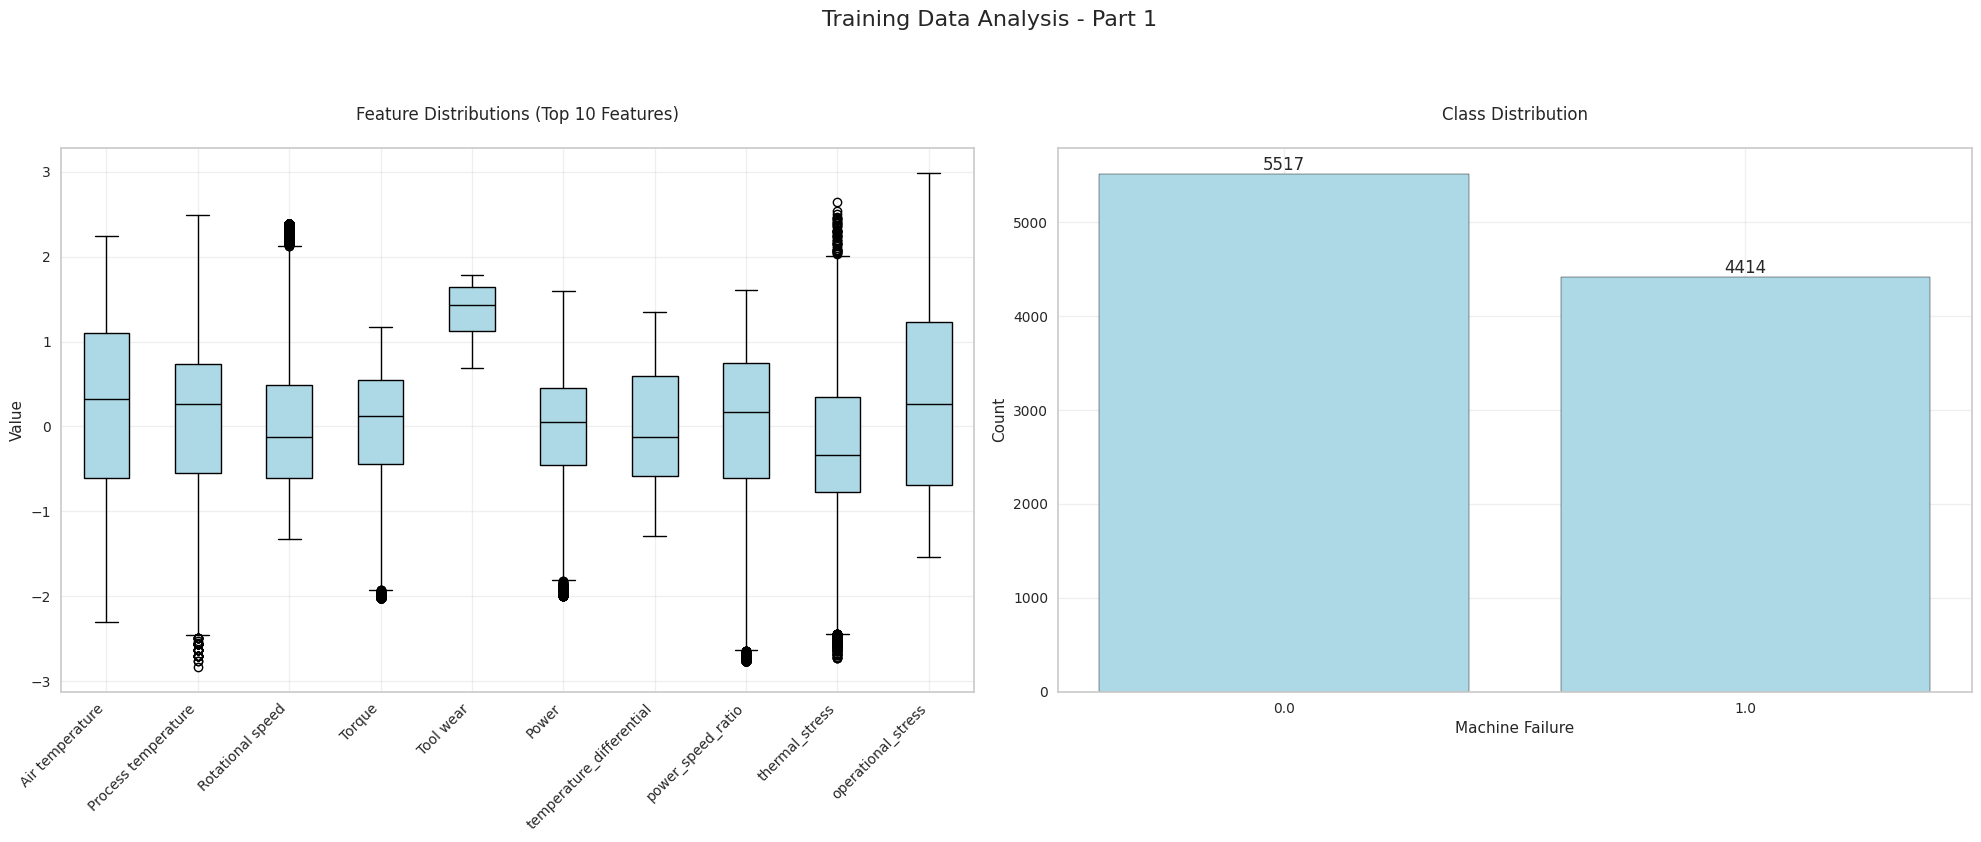

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

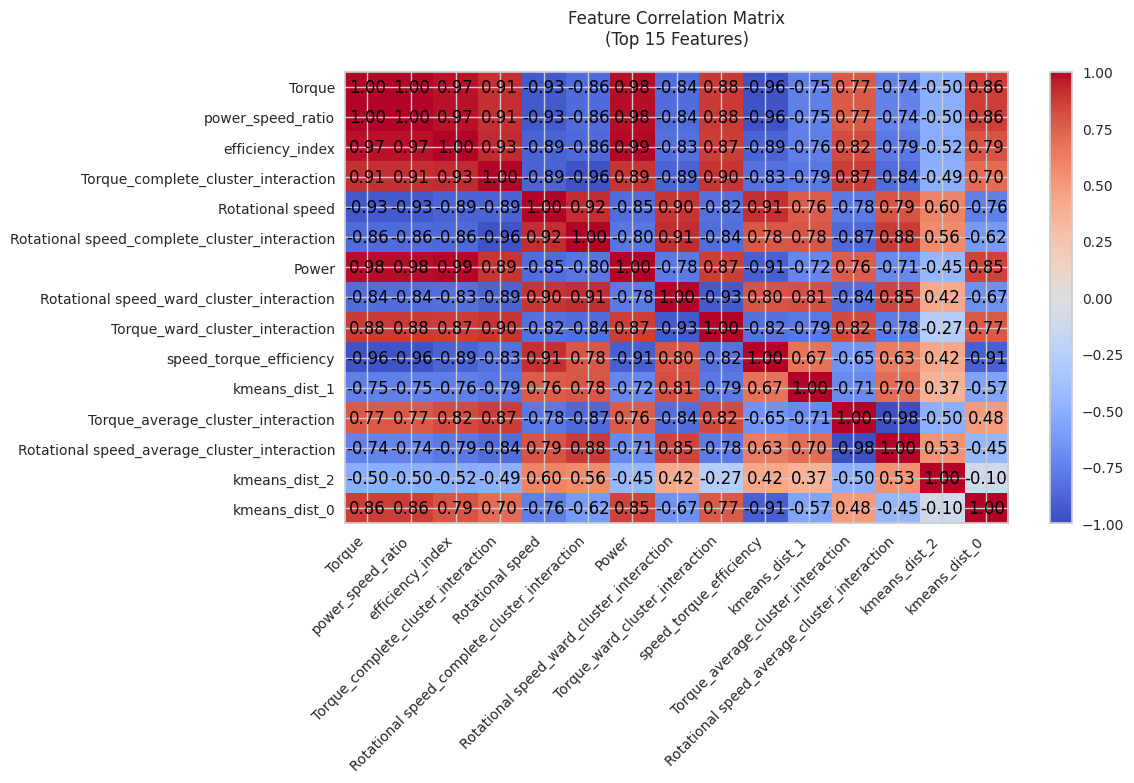

In [16]:
def visualize_train_data(X_train, y_train):
    """Visualize the training data with improved readability"""
    # Create two separate figures for better visibility
    # Figure 1: Distributions and Class Balance
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig1.suptitle('Training Data Analysis - Part 1', fontsize=16, y=1.05)
    
    # 1. Feature Distributions - Select top 10 features for better visibility
    selected_features = X_train.columns[:10] if len(X_train.columns) > 10 else X_train.columns
    X_train[selected_features].boxplot(ax=ax1, vert=True, patch_artist=True,
                                     medianprops=dict(color="black"),
                                     boxprops=dict(facecolor='lightblue', color='black'),
                                     whiskerprops=dict(color='black'),
                                     capprops=dict(color='black'))
    ax1.set_title('Feature Distributions (Top 10 Features)', pad=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Value')
    
    # 2. Class Distribution
    class_dist = pd.Series(y_train).value_counts()
    bars = ax2.bar(class_dist.index.astype(str), class_dist.values, 
                  color='lightblue', edgecolor='black')
    ax2.set_title('Class Distribution', pad=20)
    ax2.set_xlabel('Machine Failure')
    ax2.set_ylabel('Count')
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 2: Correlation Matrix
    fig2, ax3 = plt.subplots(figsize=(12, 8))
    corr_matrix = X_train.corr()
    
    # Select top 15 features based on correlation with other features
    top_corr_features = corr_matrix.abs().mean().sort_values(ascending=False)[:15].index
    
    # Plot correlation matrix for top features
    im = ax3.imshow(corr_matrix.loc[top_corr_features, top_corr_features], 
                   cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # Add colorbar
    plt.colorbar(im)
    
    # Add correlation values
    for i in range(len(top_corr_features)):
        for j in range(len(top_corr_features)):
            text = ax3.text(j, i, f'{corr_matrix.loc[top_corr_features, top_corr_features].iloc[i, j]:.2f}',
                          ha="center", va="center", color="black")
    
    # Set labels
    ax3.set_xticks(np.arange(len(top_corr_features)))
    ax3.set_yticks(np.arange(len(top_corr_features)))
    ax3.set_xticklabels(top_corr_features, rotation=45, ha='right')
    ax3.set_yticklabels(top_corr_features)
    plt.title('Feature Correlation Matrix\n(Top 15 Features)', pad=20)
    
    # Print summary statistics
    print("\nTraining Data Summary:")
    print(f"Number of samples: {len(X_train)}")
    print(f"Number of features: {X_train.shape[1]}")
    print("\nClass Balance:")
    print(pd.Series(y_train).value_counts(normalize=True).round(3))
    
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2

# Visualize the training data
fig1, fig2 = visualize_train_data(X, y)

### saving with all new features

In [17]:
df_combined = pd.concat([X, y], axis=1)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9931 entries, 0 to 9930
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Air temperature                                   9931 non-null   float64
 1   Process temperature                               9931 non-null   float64
 2   Rotational speed                                  9931 non-null   float64
 3   Torque                                            9931 non-null   float64
 4   Tool wear                                         9931 non-null   float64
 5   Power                                             9931 non-null   float64
 6   temperature_differential                          9931 non-null   float64
 7   power_speed_ratio                                 9931 non-null   float64
 8   thermal_stress                                    9931 non-null   float64
 9   operational_stress 

In [18]:
df_combined.to_csv("clustering_preprocessed_data.csv", index=False)